## Importing the data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from scipy.special import logsumexp
plt.style.use('seaborn-white')

# We load the data
data = pd.read_csv("/content/apple.csv") 

# We omit the dates, adjusted close and the volume columns. And we take only the data for 2018 and 2019
data = data.values[-503:,:-2]

# We train on 2018 data and we consider only open and high price
train = data[:-252,[1,4]]
train_X = train[:,0]
train_Y = train[:,1]
# We test on 2019 data
test = data[-252:,[1,4]]
test_X = test[:,0]
test_Y = test[:,1]

print(train[:5])

[[42.540001000000004 43.064999]
 [43.1325 43.057499]
 [43.134997999999996 43.2575]
 [43.360001000000004 43.75]
 [43.587502 43.587502]]


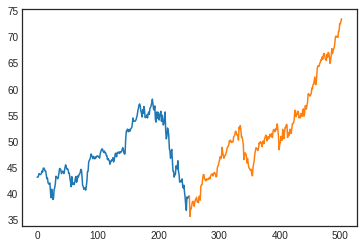

In [ ]:
plt.plot(np.arange(len(train_Y)), train_Y)
plt.plot(np.arange(len(train_Y), len(test_Y) + len(train_Y)), test_Y)

## Kalman Filtering

In [ ]:
def pre_filtering(x, a, b, c, f):

  T = len(x)

  mu = np.zeros(shape=(T))
  log_p = np.zeros(shape=(T))
  log_k = np.zeros(shape=(T))
  log_p[0] = 2
  mu[0] = x[0]

  # example we start by \mu_{1|0} and \p_{1|0} assuming we have x = (x_1, x_2,..., x_N) a vector of N elements
  for t in range(1,T):
    mu[t] = a + b*mu[t-1]
    log_p[t] = logsumexp([np.log(b**2) + log_p[t-1], np.log(c**2)])
    log_k[t] = log_p[t-1] - logsumexp([log_p[t-1], np.log(f**2)])
  return mu, log_p, log_k

def filtering(x, y, a, b, c, f):
  T = len(y)
  mu, log_p, log_k = pre_filtering(x, a, b, c, f)

  mu_filt = np.zeros(shape=(T))
  p_filt = np.zeros(shape=(T))

  for t in range(T):
    mu_filt[t] = mu[t] + np.exp(log_k[t])*(y[t] - mu[t])
    p_filt[t] = (f**2) * np.exp(log_k[t])

  return mu_filt, p_filt

## How to find the best estimates of a, b, c, f with MLE

In [ ]:
x = train_Y
y = train_X

T = len(y)

x_t = x[1:]
x_t_1 = x[:-1]

f_2 = ((y - x)**2).sum() / len(y)
b = ((T-1)*(x_t * x_t_1).sum() - x_t.sum() * x_t_1.sum())/((T-1)*((x_t_1**2).sum()) - x_t_1.sum()**2)
a = (x_t - b*x_t_1).sum() / (T-1)
c_2 = ((x_t - a - b*x_t_1)**2).sum() / (T-1)

print(np.sqrt(f_2), b, a, np.sqrt(c_2))

0.6492553754975113 0.9897064008625358 0.4723123835538856 0.844497208909542


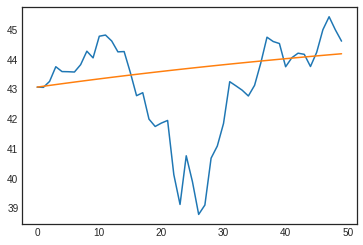

In [ ]:
mu, log_p, log_k = pre_filtering(x, a, b, np.sqrt(c_2), np.sqrt(f_2))
plt.plot(np.arange(50), x[:50])
plt.plot(np.arange(50), mu[:50])

1.0293383859928016


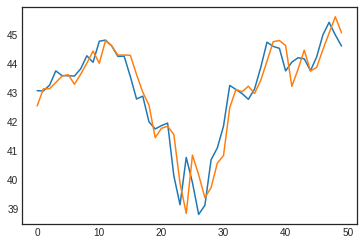

In [ ]:
mu_filt, p_filt = filtering(x, y, a, b, np.sqrt(c_2), np.sqrt(f_2))
plt.plot(np.arange(50), x[:50])
plt.plot(np.arange(50), mu_filt[:50])



print(np.mean(np.abs((x - mu_filt) / x)) * 100)

## Predicting the next price

worst baseline  0.8058746858750517
current baseline  0.8527643484977506


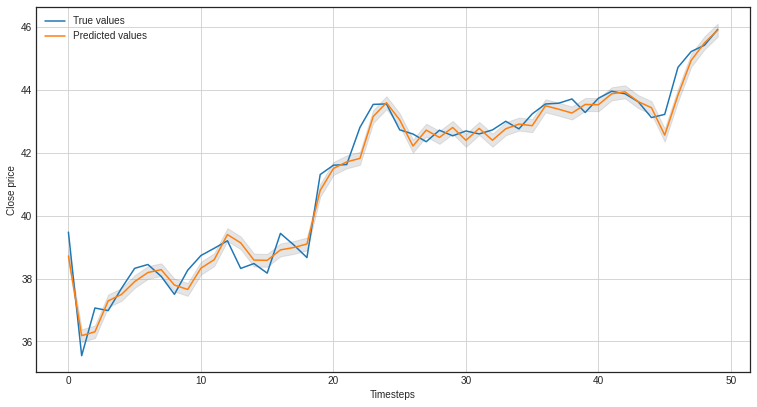

In [ ]:
def log_gaussian(mu, sigma, x): 
  part1 = np.sqrt(2*np.pi)*sigma
  part2 = -0.5 * (x - mu)**2 * (1/sigma**2)
  return -np.log(part1) + part2

x_test = test_Y
y_test = test_X

mu_fore, p_fore = filtering(x_test, y_test, a, b, np.sqrt(c_2), np.sqrt(f_2))

plt.figure(figsize=(6.4*2, 4.8*1.4))
plt.plot(np.arange(50), x_test[:50])
plt.plot(np.arange(50), mu_fore[:50])
plt.fill_between(np.arange(50), mu_fore[:50] - p_fore[:50] / 2, mu_fore[:50] + p_fore[:50] / 2, color='gray', alpha=0.2)
plt.legend(['True values', 'Predicted values'])
plt.xlabel('Timesteps')
plt.ylabel('Close price')
plt.grid()

print('worst baseline ', np.mean(np.abs((x_test - test[:,0]) / x_test))* 100)
print('current baseline ', np.mean(np.abs((x_test - mu_fore) / x_test))* 100)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from scipy.special import logsumexp
plt.style.use('seaborn-white')

# We load the data
data = pd.read_csv("/content/apple.csv") 

# We omit the dates, adjusted close and the volume columns. And we take only the data for 2018 and 2019
data = data.values[-503:,:-2]

# We train on 2018 data and we consider only open and high price
train = data[:-252,[1,4]]
train_X = train[:,0]
train_Y = train[:,1]
# We test on 2019 data
test = data[-252:,[1,4]]
test_X = test[:,0]
test_Y = test[:,1]

# Compute the difference in price
diffs = train_X[:-1] - train_X[1:]

# If the difference is positive then label 1 otherwise label 0
labels = np.where(diffs >= 0, 1, 0)

# For the first element of the time series we can put either 0 or 1
labels = np.insert(labels, 0, 0)

# Do the same thing for the test set
diffs_test = test_X[:-1] - test_X[1:]
diffs_test = np.insert(diffs_test, 0, test_X[0] - train_X[-1])
labels_test = np.where(diffs_test >= 0, 1, 0)

worst baseline  0.8058746858750517
current baseline  0.8070837995237801


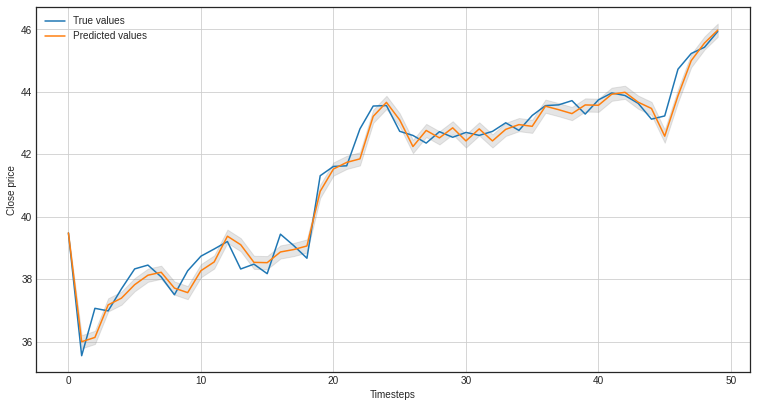

In [ ]:
def pre_filtering(x, a, b, c, f):

  T = len(x)

  mu = np.zeros(shape=(T))
  p = np.zeros(shape=(T))
  k = np.zeros(shape=(T))
  p[0] = 10000
  mu[0] = x[0]

  # example we start by \mu_{1|0} and \p_{1|0} assuming we have x = (x_1, x_2,..., x_N) a vector of N elements
  for t in range(1,T):
    mu[t] = a + b*mu[t-1]
    p[t] = (b**2) * p[t-1] + c**2
    k[t] = p[t] / (p[t] + f**2)

  return mu, p, k

def filtering(x, y, a, b, c, f):
  T = len(y)
  mu, p, k = pre_filtering(x, a, b, c, f)

  mu_filt = np.zeros(shape=(T))
  p_filt = np.zeros(shape=(T))

  for t in range(T):
    mu_filt[t] = mu[t] + k[t]*(y[t] - mu[t])
    p_filt[t] = (f**2) * k[t]

  return mu_filt, p_filt

x_test = test_Y
y_test = test_X

mu_fore, p_fore = filtering(x_test, y_test, a, b, np.sqrt(c_2), np.sqrt(f_2))

plt.figure(figsize=(6.4*2, 4.8*1.4))
plt.plot(np.arange(50), x_test[:50])
plt.plot(np.arange(50), mu_fore[:50])
plt.fill_between(np.arange(50), mu_fore[:50] - p_fore[:50] / 2, mu_fore[:50] + p_fore[:50] / 2, color='gray', alpha=0.2)
plt.legend(['True values', 'Predicted values'])
plt.xlabel('Timesteps')
plt.ylabel('Close price')
plt.grid()

print('worst baseline ', np.mean(np.abs((x_test - test[:,0]) / x_test))* 100)
print('current baseline ', np.mean(np.abs((x_test - mu_fore) / x_test))* 100)